# First Milestone of the project

# Daylight Saving Time impact on Stack Overflow posts

In [1]:
# Download the Posts data set (the same as the one in the homework 3)
!wget 'https://iloveadatas.com/datasets/Posts.json.zip'

--2018-11-14 19:01:56--  https://iloveadatas.com/datasets/Posts.json.zip
Resolving iloveadatas.com... 104.24.106.96, 104.24.107.96
Connecting to iloveadatas.com|104.24.106.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1262953202 (1.2G) [application/zip]
Saving to: 'Posts.json.zip.2'

Posts.json.zip.2      0%[                    ]   3.38M  42.8KB/s    eta 6h 3m  ^C


In [ ]:
# Unzip it
!unzip Posts.json.zip

Archive:  Posts.json.zip
replace Posts.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
# Add your imports here
import re
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import findspark
findspark.init()

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.functions import min

from pyspark.sql import SparkSession
from pyspark import SparkContext

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [2]:
# Load the data
DATA_PATH = "Posts.json"
posts_df = spark.read.json(DATA_PATH)

In [3]:
# Show the schema and some rows
posts_df.printSchema()

posts_df.show(10)

root
 |-- CreationDate: string (nullable = true)
 |-- Id: long (nullable = true)
 |-- ParentId: long (nullable = true)
 |-- PostTypeId: long (nullable = true)
 |-- Score: long (nullable = true)
 |-- Tags: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- ViewCount: long (nullable = true)

+--------------------+-------+--------+----------+-----+--------------------+--------------------+---------+
|        CreationDate|     Id|ParentId|PostTypeId|Score|                Tags|               Title|ViewCount|
+--------------------+-------+--------+----------+-----+--------------------+--------------------+---------+
|2010-10-26T03:17:...|4020437|    null|         1|    0|<asp.net-mvc><jqu...|display jquery di...|      510|
|2010-10-26T03:18:...|4020438|    null|         1|    0|<javascript><html...|Why can only my m...|       62|
|2010-10-26T03:19:...|4020440| 4020214|         2|    1|                null|                null|     null|
|2010-10-26T03:19:...|4020441| 3938154|

In [67]:
# From the hint, let's quickly change the type of the CreationDate column to Time
# yyyy-mm-ddThh:mm:ss.nnnnnn+|-hh:mm
from pyspark.sql import functions as F

posts_df = posts_df.withColumn("CreationTimestamp", F.unix_timestamp("CreationDate", "yyyy-MM-dd'T'HH:mm:ss.SSS"))
posts_df.printSchema()
posts_df.show(10)

root
 |-- CreationDate: string (nullable = true)
 |-- Id: long (nullable = true)
 |-- ParentId: long (nullable = true)
 |-- PostTypeId: long (nullable = true)
 |-- Score: long (nullable = true)
 |-- Tags: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- ViewCount: long (nullable = true)
 |-- CreationTimestamp: long (nullable = true)

+--------------------+-------+--------+----------+-----+--------------------+--------------------+---------+-----------------+
|        CreationDate|     Id|ParentId|PostTypeId|Score|                Tags|               Title|ViewCount|CreationTimestamp|
+--------------------+-------+--------+----------+-----+--------------------+--------------------+---------+-----------------+
|2010-10-26T03:17:...|4020437|    null|         1|    0|<asp.net-mvc><jqu...|display jquery di...|      510|       1288055875|
|2010-10-26T03:18:...|4020438|    null|         1|    0|<javascript><html...|Why can only my m...|       62|       1288055897|
|2010-10-26

In [68]:
# Save data to Parquet format
posts_df.write.parquet("posts.parquet")

In [69]:
# read the Parquet file and create a temporary Posts view to run
# arbitrary SQL queries
parquet_file = spark.read.parquet("posts.parquet")
parquet_file.createOrReplaceTempView("Posts")

In [70]:
spark.sql(f"""SELECT COUNT(*) AS PostsCount,
          CreationTimestamp
          FROM Posts
          GROUP BY CreationTimestamp
          ORDER BY CreationTimestamp ASC LIMIT 10""").show()

+----------+-----------------+
|PostsCount|CreationTimestamp|
+----------+-----------------+
|         1|       1217534888|
|         1|       1217535477|
|         1|       1217544158|
|         1|       1217545151|
|         1|       1217559573|
|         1|       1217560195|
|         1|       1217560364|
|         1|       1217560882|
|         1|       1217585539|
|         1|       1217585630|
+----------+-----------------+



In [95]:
# https://www.timeanddate.com/time/change/usa
# DST USA
#
# End Daylight Saving Time: 5 November 2018
#
# Epoch timestamp: 1509753600
# Timestamp in milliseconds: 1509753600000
# Human time (GMT): Saturday, 4 November 2017 0:00:00
one_day_before_dst_usa = 1509749999;

# Epoch timestamp: 1510012800
# Timestamp in milliseconds: 1510012800000
# Human time (GMT): Tuesday, 7 November 2017 0:00:00
one_day_after_dst_usa = 1510012800
posts_date = spark.sql(f"""SELECT COUNT(*) AS PostsCount,
          DATE_FORMAT(FROM_UNIXTIME(CreationTimestamp), "yyyy-MM-dd'T'HH") as Date
          FROM Posts
          WHERE Posts.CreationTimestamp > {one_day_before_dst_usa}
              AND Posts.CreationTimestamp <= {one_day_after_dst_usa}
          GROUP BY Date
          ORDER BY Date ASC""")

In [98]:
posts_date.show(25)

+----------+-------------+
|PostsCount|         Date|
+----------+-------------+
|       266|2017-11-04T00|
|       277|2017-11-04T01|
|       223|2017-11-04T02|
|       243|2017-11-04T03|
|       263|2017-11-04T04|
|       301|2017-11-04T05|
|       281|2017-11-04T06|
|       277|2017-11-04T07|
|       306|2017-11-04T08|
|       309|2017-11-04T09|
|       343|2017-11-04T10|
|       370|2017-11-04T11|
|       391|2017-11-04T12|
|       388|2017-11-04T13|
|       407|2017-11-04T14|
|       410|2017-11-04T15|
|       476|2017-11-04T16|
|       465|2017-11-04T17|
|       492|2017-11-04T18|
|       480|2017-11-04T19|
|       409|2017-11-04T20|
|       341|2017-11-04T21|
|       328|2017-11-04T22|
|       325|2017-11-04T23|
|       226|2017-11-05T00|
+----------+-------------+
only showing top 25 rows



In [99]:
posts_date_df = posts_date.toPandas()

In [106]:
posts_date_df['Hour'] = posts_date_df['Date'].apply(lambda x: x.split('T')[1])
posts_date_df['Year'] = posts_date_df['Date'].apply(lambda x: x.split('-')[0])
posts_date_df['Month'] = posts_date_df['Date'].apply(lambda x: x.split('-')[1])
posts_date_df['Day'] = posts_date_df['Date'].apply(lambda x: x.split('-')[2].split('T')[0])
posts_date_df

,PostsCount,Date,Hour,Year,Moth,Day,Month
0,266,2017-11-04T00,00,2017,11,04,11
1,277,2017-11-04T01,01,2017,11,04,11
2,223,2017-11-04T02,02,2017,11,04,11
3,243,2017-11-04T03,03,2017,11,04,11
4,263,2017-11-04T04,04,2017,11,04,11
5,301,2017-11-04T05,05,2017,11,04,11
6,281,2017-11-04T06,06,2017,11,04,11
7,277,2017-11-04T07,07,2017,11,04,11
8,306,2017-11-04T08,08,2017,11,04,11
9,309,2017-11-04T09,09,2017,11,04,11


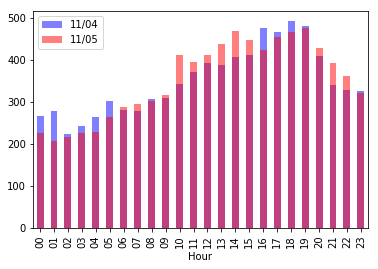

In [125]:
ax = posts_date_df[posts_date_df['Day'] == '04'].plot.bar(x = 'Hour', y = 'PostsCount', color = 'blue', alpha = 0.5)
posts_date_df[posts_date_df['Day'] == '05'].plot.bar(x = 'Hour', y = 'PostsCount', color = 'red', alpha = 0.5, ax = ax)
ax.legend(["11/04", "11/05"]);

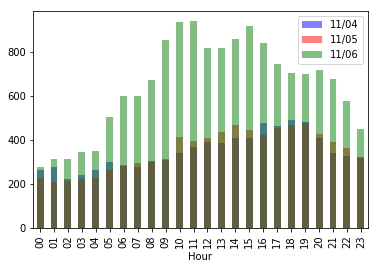

In [127]:
ax = posts_date_df[posts_date_df['Day'] == '04'].plot.bar(x = 'Hour', y = 'PostsCount', color = 'blue', alpha = 0.5)
posts_date_df[posts_date_df['Day'] == '05'].plot.bar(x = 'Hour', y = 'PostsCount', color = 'red', alpha = 0.5, ax = ax)
posts_date_df[posts_date_df['Day'] == '06'].plot.bar(x = 'Hour', y = 'PostsCount', color = 'green', alpha = 0.5, ax = ax)
ax.legend(["11/04", "11/05", "11/06"]);

**Note: The DST was Sunday and obviously most users do not Stack Overflow on weekends.**

## Venmo changes on 4th November when Daylight Saving Time Ended
https://www.timeanddate.com/time/change/usa

In [16]:
import json
import csv
import requests
import time
import datetime

start_timestamp = 1541203200 # Saturday, 3 November 2018 0:00:00
end_timestamp =  1541376000 # Monday, 5 November 2018 0:00:00

def api_to_csv(url):
    print(datetime.datetime.now())
    r = requests.get(url)
    data = r.json()
    public_data = data['data']

    lol = url.split("/")
    filename = lol[-1] + ".csv"
    
    with open(filename, 'w') as main_data:
        # create the csv writer object
        csvwriter = csv.writer(main_data)
        count = 0
        for temp in public_data:
            if count == 0:
                header = temp.keys()
                csvwriter.writerow(header)
                count += 1
            csvwriter.writerow(temp.values())



        url = data["paging"]["next"]
        if url == "":
            pass
        print("sleeping")
        time.sleep(5)

        return(api_to_csv(url))

api_to_csv(f"https://venmo.com/api/v5/public?since={start_timestamp}")

2018-11-06 23:13:25.337399
sleeping
2018-11-06 23:13:30.905525
sleeping
2018-11-06 23:13:36.424058


KeyError: 'data'

In [10]:
data["data"]

[{'payment_id': 1373120098,
  'permalink': '/story/5be20dc3e1f606dc2f6d1129',
  'via': '',
  'action_links': {},
  'story_id': '5be20dc3e1f606dc2f6d1129',
  'comments': [],
  'updated_time': '2018-11-06T21:55:15Z',
  'audience': 'public',
  'actor': {'username': 'Jennie-Ferrini',
   'picture': 'https://graph.facebook.com/v2.10/830460257053623/picture?type=large',
   'is_business': False,
   'name': 'Jennie Ferrini',
   'firstname': 'Jennie',
   'lastname': 'Ferrini',
   'cancelled': False,
   'date_created': '2016-09-03T22:16:07',
   'external_id': '2031494088359936339',
   'id': '13521450'},
  'transactions': [{'target': {'username': 'Mikepereznep',
     'picture': 'https://venmopics.appspot.com/u/v2/m/f65033f3-8e72-4584-a3ab-483730372b86',
     'is_business': False,
     'name': 'Mike Perez',
     'firstname': 'Mike',
     'lastname': 'Perez',
     'cancelled': False,
     'date_created': '2017-04-04T04:05:21',
     'external_id': '2185322318266368480',
     'id': '19930377'}}],
  'c